In [1]:
# import autograd functionalities
import autograd.numpy as np
from autograd import grad as compute_grad   

# import plotting library and other necessities
import matplotlib.pyplot as plt
from matplotlib import gridspec

# import general libraries
import copy
from datetime import datetime 

##### import custom libs #####
import normalizers
from convnet import superlearn_setup as setup_multi

#this is needed to compensate for matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

import sys
sys.path.append('../../')

from timeit import default_timer as timer

%load_ext autoreload
%autoreload 2

# load in color image data

Load in a chunk of the CIFAR-10 database.

In [2]:
## Load colorful image data
from autograd import grad as compute_grad   
import autograd.numpy as np

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

image_data_1 = unpickle('datasets/cifar_10/data_batch_1')
x1 = image_data_1[b'data'].T
y1 = np.array(image_data_1[b'labels'])[np.newaxis,:]

image_data_2 = unpickle('datasets/cifar_10/data_batch_2')
x2 = image_data_2[b'data'].T
y2 = np.array(image_data_2[b'labels'])[np.newaxis,:]

image_data_3 = unpickle('datasets/cifar_10/data_batch_3')
x3 = image_data_3[b'data'].T
y3 = np.array(image_data_3[b'labels'])[np.newaxis,:]

image_data_4 = unpickle('datasets/cifar_10/data_batch_4')
x4 = image_data_4[b'data'].T
y4 = np.array(image_data_4[b'labels'])[np.newaxis,:]

image_data_5 = unpickle('datasets/cifar_10/data_batch_5')
x5 = image_data_5[b'data'].T
y5 = np.array(image_data_5[b'labels'])[np.newaxis,:]

In [3]:
x = np.concatenate((x1,x2,x3,x4,x5), axis=1)

In [4]:
y = np.concatenate((y1,y2,y3,y4,y5), axis=1)

# subsample database, we do 10 classification here.

Subsample the dataset - I take 100 random images to start, and then clump them into two classes.

In [5]:
# random subset of full dataset
num_samples = 30000
P = np.size(y) 
inds = np.random.permutation(P)[:num_samples]
x_samples = x[:,inds]
y_samples = y[:,inds]

In [6]:
print('The input image data structure is N * P')
print(np.shape(x_samples))
print('The label data structure is M * P')
print(np.shape(y_samples))

The input image data structure is N * P
(3072, 30000)
The label data structure is M * P
(1, 30000)


# contrast normalize images

In [7]:
normalizer,inverse_normalizer = normalizers.standard(x_samples.T)
x_samples = normalizer(x_samples.T).T

In [8]:
print('After Normalization, the normalized input size is :')
print(np.shape(x_samples))

After Normalization, the normalized input size is :
(3072, 30000)


# Build and tune a multilayer convnet

Below is an example using the updated API - in particular below shows an example of a convnet with one convolution layers, one pooling layer, and one activation layer - then a fully connected network on top of it with a single hidden layer. 

The CNN layer is one layer, kernel number is 8, kernel size is 3 by 3.

Note in terms of usage, there are now 5 steps to setting up a convnet using our api

1) **Setting up the experiment via** `Setup` - here we load in the data, normalize it using a standard or ZCA-sphereing.


2)  **Constructing the convnet portion of the network ** - this involves adding `conv`, `pool`, and `activation` layers.  Note when adding a conv layer via `add_conv_layer` you can turn on / off padding by setting `pad = True` or `pad = False` (note: the default is `pad = True`), control the convolution stride via the `stride` variable, `num_kernels` and `kernel_size` directly.  You can likewise control the pooling stride via the `stride` variable when adding a pooling layer via `add_pool_layer`.


3)  **Constructing the fully connected portion of the network** - You can set any number perceptron in each fully connected layers.


4)  **Choosing a cost function** - Select cost function for different problem you are solving: Regression, two-classification or multiclassification


5)  **Running an optimization** - Set the hyperparameters, notice: the each iteration means running the whole train dataset once.

6) **Saving the training result** - You can save the tuned model and reload it in next time.

7) **Make prediction based on a tuned model** - Load the tuned weights, and make prediction.

## LeNet-3

### Using our API to set LeNet-3

Since we are using CPU to train the cifar data, we just take 10 interations, and the batch size is 200. The learning rate is 0.1

iteration 1 done in 192.6 secs, train cost = 1.7571, train accuracy = 0.3698, val cost = 1.7718, val accuracy = 0.3598
iteration 2 done in 190.8 secs, train cost = 1.6158, train accuracy = 0.425, val cost = 1.6362, val accuracy = 0.4185
iteration 3 done in 192.3 secs, train cost = 1.5158, train accuracy = 0.46, val cost = 1.5505, val accuracy = 0.446
iteration 4 done in 199.6 secs, train cost = 1.4325, train accuracy = 0.4882, val cost = 1.4879, val accuracy = 0.4683
iteration 5 done in 196.6 secs, train cost = 1.3813, train accuracy = 0.5057, val cost = 1.4584, val accuracy = 0.4833
iteration 6 done in 190.2 secs, train cost = 1.3037, train accuracy = 0.5317, val cost = 1.4096, val accuracy = 0.4975
iteration 7 done in 191.1 secs, train cost = 1.2461, train accuracy = 0.5533, val cost = 1.3792, val accuracy = 0.512
iteration 8 done in 191.5 secs, train cost = 1.1888, train accuracy = 0.5755, val cost = 1.349, val accuracy = 0.5237
iteration 9 done in 195.0 secs, train cost = 1.1618, t

<IPython.core.display.Javascript object>


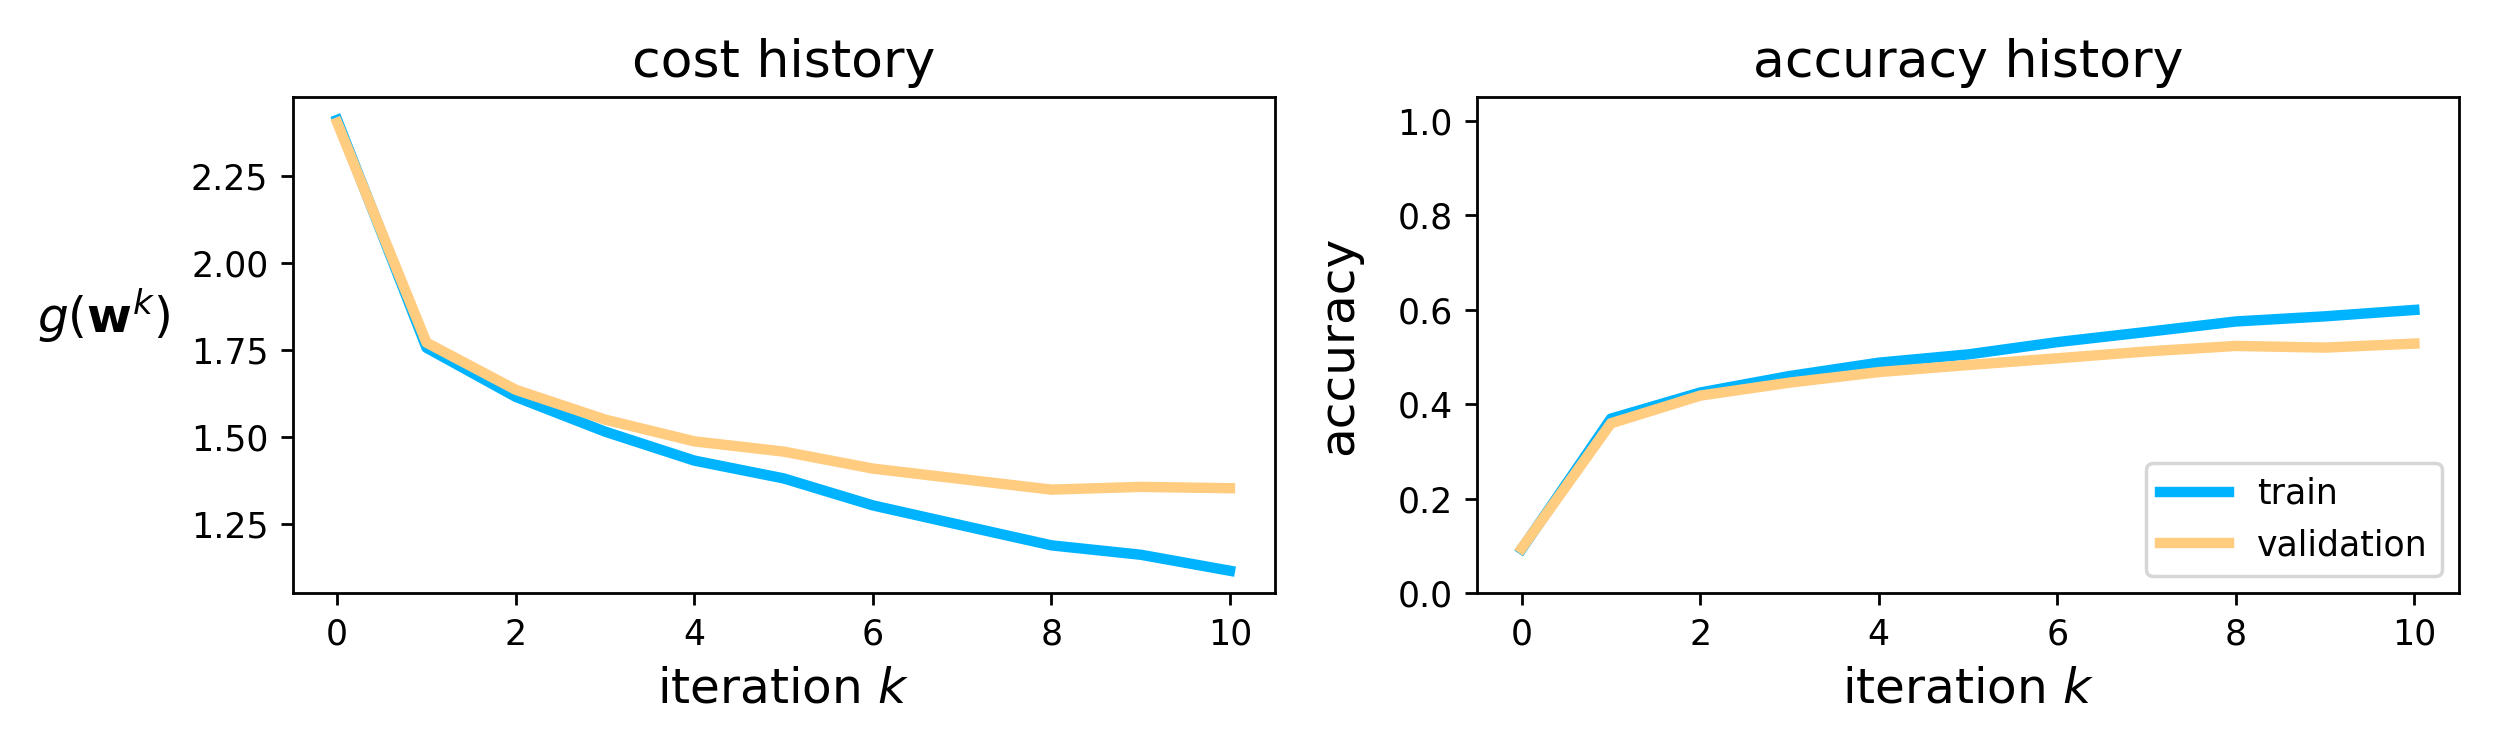

In [9]:
# Set up
mylib3 = setup_multi.Setup(x_samples,y_samples,normalizer = 'standard')

### make conv portion of network ###
### Set LeNet-5 ###

# add first conv layer --> note pad = True here, and the kernel_size = 3
num_kernels = 6; 
mylib3.add_conv_layer(num_kernels,kernel_size = 3)
# add activation layer
mylib3.add_activation_layer(activation = 'relu')
# add pool layer
mylib3.add_pool_layer(window_size=2,stride = 2)

# add second conv layer --> note pad = True here
num_kernels = 16; 
mylib3.add_conv_layer(num_kernels,kernel_size = 3)
# add activation layer
mylib3.add_activation_layer(activation = 'relu')
# add pool layer
mylib3.add_pool_layer(window_size=2,stride = 2)


# add fully connected layer
layer_sizes = [120,84]
mylib3.add_full_layers(name = 'multilayer_perceptron',layer_sizes = layer_sizes,super_type = 'classification',activation = 'maxout')

### choose cost function and run ###
mylib3.choose_cost(name = 'multiclass_softmax')

# split into training and validation sets
mylib3.make_train_val_split(train_portion = 0.8)

# run optimization
mylib3.fit(max_its = 10,alpha_choice = 10**(-1),batch_size = 200,verbose = True)

# show cost function history
mylib3.show_histories()

In [10]:
mylib3.save_best_weights('./saved_model/cifar_LeNet-3_test_best_weights')